In [13]:
# Check error space

# Import libraries
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import sys
sys.path.insert(1, '../../src')

from EM1D import EMf_2Lay_HVP, ErrorSpace_2Lay

In [10]:
# Load model and data
model = np.load('data/model_synth_2Lay_A2.npy')
data = np.load('data/data_synth_2Lay_A2.npy')
LUT = np.load('../data/LUTable_2Lay.npy')
conds = np.load('../data/conds.npy')
thicks = np.load('../data/thicks.npy')

# Load survey parameters
survey = np.load('../data/survey_2Lay.npy', allow_pickle=True).item()
offsets = survey['offsets']
height = survey['height']
freq = survey['freq']
lambd = survey['lambd']
filt = survey['filt']

# Load estimated model from Global Search
model_est = np.load('results/model_2Lay_A2_GS.npy')

In [11]:
# For example let's check the following position
pos = 10

# Simulate data for this position
data_est = EMf_2Lay_HVP(lambd, 
                        sigma1 = model_est[pos, 0],
                        sigma2 = model_est[pos, 1],
                        h1 = model_est[pos, 2],
                        height = height,
                        offsets = offsets,
                        freq = freq,
                        filt = filt)

# search the error space
err, models_err = ErrorSpace_2Lay(LUT, data_est, 0.2, conds, thicks)

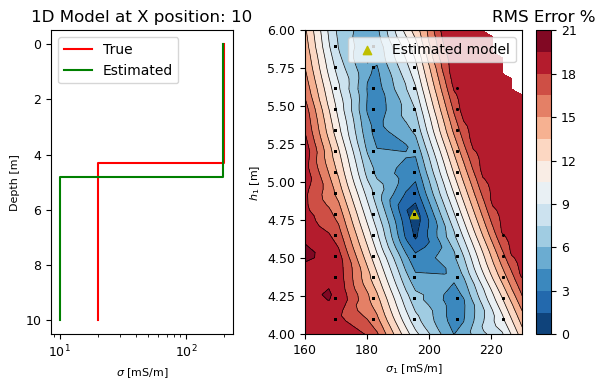

In [14]:
# Function to plot Error space

def PlotErrorSpace(model, model_est, pos, err, models_err, depthmax=10):
    # Arrays to plot
    depth_true = np.array([0, model[pos,2], depthmax])
    depth_est = np.array([0, model_est[pos,2], depthmax])

    sigma_true = np.hstack([model[pos,:2], model[pos,1]])
    sigma_est = np.hstack([model_est[pos,:2], model_est[pos,1]])
       
    fig, ax = plt.subplots(1,2, figsize=(6,4), gridspec_kw={'width_ratios': [1,1.5]})
    
    ax[0].step(sigma_true*1000, depth_true, 'r', label = 'True')
    ax[0].step(sigma_est*1000, depth_est, 'g', label='Estimated')
    ax[0].invert_yaxis()
    ax[0].set_ylabel('Depth [m]', fontsize=8)
    ax[0].set_xlabel('$\sigma$ [mS/m]', fontsize=8)
    ax[0].set_title('1D Model at X position: ' +str(pos))
    ax[0].set_xscale('log')
    ax[0].legend()

    x = ((models_err[:,0])*1000) # conductivities of first layer
    y = models_err[:,2]          # thickness of first layer
    z = err

    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax[1].contour(xi, yi, zi*100, levels=14, linewidths=0.5, colors='k')
    cntr1 = ax[1].contourf(xi, yi, zi*100, levels=14, cmap="RdBu_r")
    ax[1].plot(x, y, '.k', ms=1)
    ax[1].set(xlim=(160,230), ylim=(4,6))
    ax[1].scatter(((model_est[pos,0])*1000), model_est[pos,2],
                 marker ='^', c='y', label='Estimated model')
    ax[1].set_xlabel('$\sigma_1$ [mS/m]', fontsize=8)
    ax[1].set_ylabel('$h_1$ [m]', fontsize=8)
    ax[1].legend()
    ax[1].tick_params(axis='both',labelsize=9)
    ax[0].tick_params(axis='both',labelsize=9)
    clb = fig.colorbar(cntr1, ax=ax[1])
    clb.ax.set_title('RMS Error %')
    clb.ax.tick_params(labelsize=9)

PlotErrorSpace(model, model_est, pos, err, models_err)
plt.tight_layout()
plt.show()